# MNIST Classification using CNN

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 1e-1

In [4]:
# Import MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

In [5]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


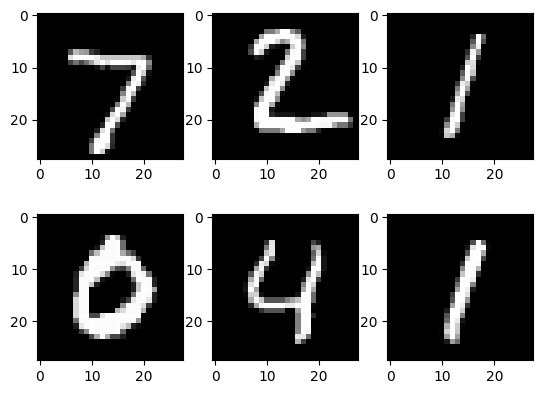

In [6]:
#plotting some examples from the MNIST dataset
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

## Convolution layer

The formulas relating the output shape of the convolution to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$



## Pooling layer 

The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The two types of pooling layers are: 

As there's no padding, the formulas binding the output shape of the pooling to the input shape is:

$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$

$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$

$$ n_C = n_{C_{prev}}$$


In [7]:
class CNN_without_bn(nn.Module):
    def __init__(self):
        super(CNN_without_bn,self).__init__()
        #layer 1 input 28x28x1 in 64 batches so in_channels=1
        #out_channels will be 32 as we are using 32 filters 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=1), 
            #output of conv layer will be H=28,W=28,C=32 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
            #output of maxpool layer H=14,W=14,C=32
        )
    
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1),
            #output of conv layer will be H=14,W=14,C=32 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
            #output of maxpool layer will H=7,W=7,C=32
        )
        self.layer3 = nn.Sequential(
            nn.Linear(7*7*32,500), #fully connected layer with linear activation
            nn.ReLU()
        )
        self.layer4 = nn.Linear(500,10) #fully connected layer with linear activation(output layer)
    def forward(self,x):
        out = self.layer1(x.float())
        out = self.layer2(out)
        out = self.layer3(out.view(out.size(0),-1))
        out = self.layer4(out)
        return F.log_softmax(out, dim=1)


In [8]:
# Fully connected neural network with one hidden layer
class CNN_with_bn(nn.Module):
    def __init__(self):
        super(CNN_with_bn,self).__init__()
        #in_channels for layer 1 input 28x28x1 in 64 batches so in_channels=1
        #out_channels will be 32 as we are using 32 filters 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=1), 
            #output of conv layer will be H=28,W=28,C=32 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
            #output of maxpool layer H=14,W=14,C=32
        )
    
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1),
            #in_channels =32 and out_channels=32
            #output of conv layer will be H=14,W=14,C=32 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
            #output of maxpool layer will H=7,W=7,C=32
        )
        self.layer3 = nn.Sequential(
            nn.Linear(7*7*32,500), #fully connected layer with linear activation
            nn.ReLU()
        )
        self.layer4 = nn.Linear(500,10) #fully connected layer with linear activation(output layer)
    def forward(self,x):
        out = self.layer1(x.float())
        out = self.layer2(out)
        out = self.layer3(out.view(out.size(0),-1))
        out = self.layer4(out)
        return F.log_softmax(out, dim=1)


In [9]:
model_without_bn = CNN_without_bn().to(device)

In [10]:
model_with_bn = CNN_with_bn().to(device)

In [11]:
# Loss function
Loss_function = nn.CrossEntropyLoss()

In [12]:
#Training the model
def train(model,train_loader, optimizer, epoch, loss_list,bn):
    if bn==True:
        print("Training CNN model with batch Normalization")
    else:
        print("Training CNN model without batch Normalization")
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        optimizer.zero_grad()
        loss = Loss_function(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx%100==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(epoch, batch_idx*len(data), len(train_loader.dataset), 100.0*batch_idx/len(train_loader), loss.item()))
        loss_list.append(loss.item())

In [13]:
### Testing the model
def test(model,test_loader, test_losses, accuracies,bn):
    if bn==True:
        print("Testing CNN model with batch Normalization")
    else:
        print("Testing CNN model without batch Normalization")
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += Loss_function(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct/len(test_loader.dataset)
    print('\nTest set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100.0*accuracy))
    test_losses.append(test_loss)
    accuracies.append(accuracy)

In [14]:
train_losses_without_bn = []
test_losses_without_bn = []
accuracies_without_bn = []
train_losses_with_bn = []
test_losses_with_bn = []
accuracies_with_bn = []

In [15]:
select_model = int(input("\nChoose the CNN model with or without batch Normalization\n1.model_without_bn \n2.model_with_bn\n"))
if select_model==1:
    model = model_without_bn
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_losses = train_losses_without_bn 
    test_losses = test_losses_without_bn 
    accuracies = accuracies_without_bn
    bn = False
else:
    model = model_with_bn
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_losses = train_losses_with_bn 
    test_losses = test_losses_with_bn 
    accuracies = accuracies_with_bn
    bn = True


Choose the CNN model with or without batch Normalization
1.model_without_bn 
2.model_with_bn
1


In [16]:
for epoch in range(1, num_epochs+1):
        train(model, train_loader, optimizer, epoch, train_losses,bn)
        test(model, test_loader, test_losses, accuracies,bn)

Training CNN model without batch Normalization
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295609

Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.426484

Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.444854

Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.173543

Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.226599

Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.276752

Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.024170

Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.213112

Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.144974

Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.070500

Testing CNN model without batch Normalization

Test set: Average Loss: 0.0013, Accuracy: 9731/10000 (97.310%)

Training CNN model without batch Normalization
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.160120

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.041057

Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.066743

Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.104520

Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.089219

Train Epoch: 2 [32000/60000 (53%)]	Loss: 0

In [17]:
select_model = int(input("\nChoose the CNN model with or without batch Normalization\n1.model_without_bn \n2.model_with_bn\n"))
if select_model==1:
    model = model_without_bn
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_losses = train_losses_without_bn 
    test_losses = test_losses_without_bn 
    accuracies = accuracies_without_bn
    bn = False
else:
    model = model_with_bn
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_losses = train_losses_with_bn 
    test_losses = test_losses_with_bn 
    accuracies = accuracies_with_bn
    bn = True


Choose the CNN model with or without batch Normalization
1.model_without_bn 
2.model_with_bn
2


In [18]:
for epoch in range(1, num_epochs+1):
        train(model, train_loader, optimizer, epoch, train_losses,bn)
        test(model, test_loader, test_losses, accuracies,bn)

Training CNN model with batch Normalization
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297154

Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.180044

Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.086123

Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.074675

Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.053989

Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.027736

Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.067658

Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.079825

Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.081791

Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.075582

Testing CNN model with batch Normalization

Test set: Average Loss: 0.0008, Accuracy: 9831/10000 (98.310%)

Training CNN model with batch Normalization
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.028860

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.042807

Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.037808

Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.014615

Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.006230

Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.086302



**1. Show the plot of training error, validation error and prediction accuracy as the training progresses. At the end of
   training, report the average prediction accuracy for the whole test set of 10000 images.**

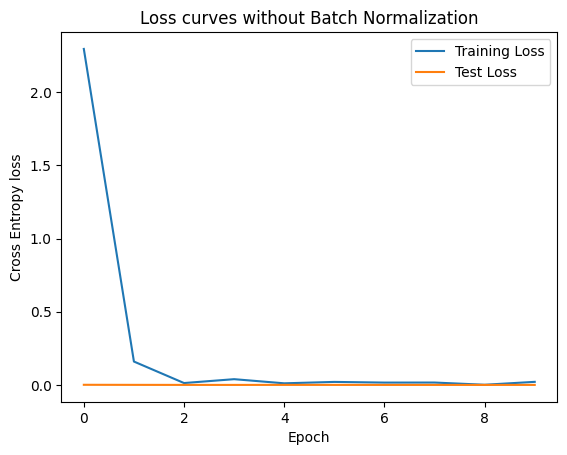

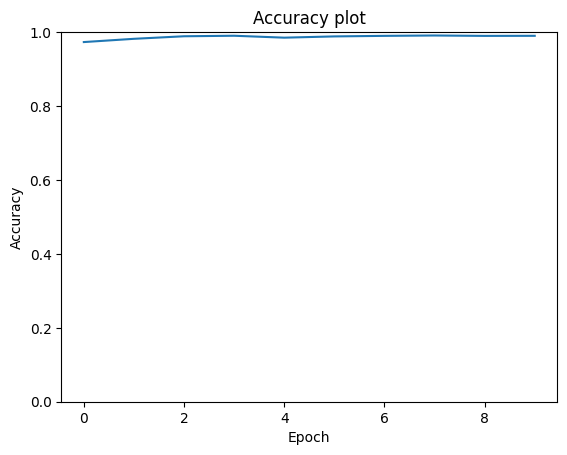

In [19]:
# Plotting the loss curves without Batch Normalization
interval = int(len(train_losses_without_bn)/num_epochs)
plt.plot(np.asarray(train_losses_without_bn)[::interval])
plt.plot(np.asarray(test_losses_without_bn))
plt.title("Loss curves without Batch Normalization")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy loss")
plt.legend(["Training Loss", "Test Loss"])
plt.show()
plt.plot(np.asarray(accuracies_without_bn))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")
plt.ylim(0,1)
plt.show()

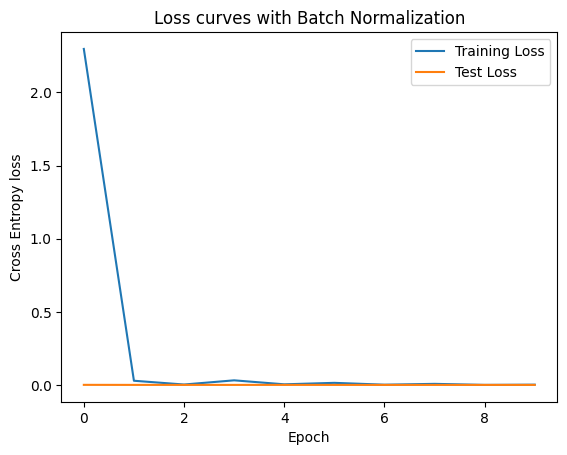

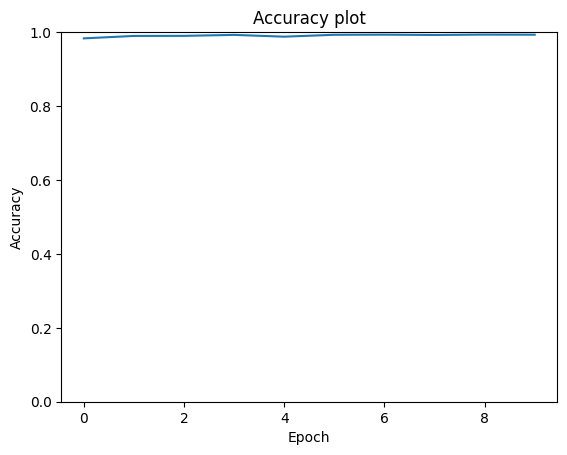

In [20]:
# Plotting loss curves with Batch Normalization
interval = int(len(train_losses_with_bn)/num_epochs)
plt.plot(np.asarray(train_losses_with_bn)[::interval])
plt.plot(np.asarray(test_losses_with_bn))
plt.title("Loss curves with Batch Normalization")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy loss")
plt.legend(["Training Loss", "Test Loss"])
plt.show()
plt.plot(np.asarray(accuracies_with_bn))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")
plt.ylim(0,1)
plt.show()

In [21]:
print("Average Prediction accuracy without batch normalization",np.mean(accuracies_without_bn)*100)
print("Average Prediction accuracy with batch normalization",np.mean(accuracies_with_bn)*100)

Average Prediction accuracy without batch normalization 98.68
Average Prediction accuracy with batch normalization 99.07400000000001


In [22]:
#As the network with batch normalization has good accuracy than without batch normalization, 
#considering the model with batch normalization for further part of the assignment
model = model_with_bn

**2. Plot randomly selected test images showing the true and predicted class labels.**

In [25]:
def predict(test_image):
    with torch.no_grad():
        if (device==torch.device("cuda")):
            test_image = test_image.reshape(1,1,28,28).cuda().float()
        else:
            test_image = test_image.reshape(1,1,28,28).float()
        out = model.forward(test_image).detach().cpu().numpy()
    predicted_class = np.argmax(out)
    plt.imshow(test_image.detach().cpu().numpy().reshape(28,28),cmap='gray')
    plt.title(f"Predicted class is {predicted_class}")
    plt.show()

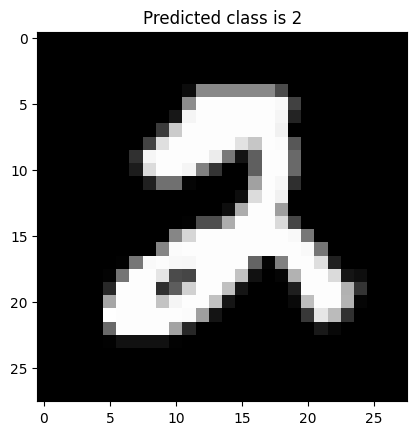

In [26]:
import random
index = random.randint(0,9999)
test_image = test_loader.dataset.data[index, :, :].clone()
predict(test_image)

**3. Report the dimensions of the input and output at each layer.**<br>
**4. How many parameters does your network have? How many of thes are in the fully connected layers and how many are
   in the convolutional layers?**<br>

1. ***Input*** image of size 28x28x1 <br>
<br>
2. ***Layer1:*** <br>
    *Conv2D:*
    1. Input- 28x28x1, Kernels=32, Kernel spatiality(F) = 3 i.e. 3x3x1 filters, Stride(S)=1, Padding(P)=1
    2. Output dimensions will be 28x28x32
    3. Parameters = 32x(3x3x1) = 288    <br>
    *Maxpool2D:*
    1. Input-28x28x32, Stride=2, Kernel_size =2
    2. Output dimensions will be 14x14x32<br>
    3. Parameters = 0    <br>
    <br>
3. ***Layer2:*** <br>
    *Conv2D:*
    1. Input- 14x14x32, Kernels=32, Kernel spatiality(F) = 3 i.e. 3x3x32 filters, Stride(S)=1, Padding(P)=1
    2. Output dimensions will be 14x14x32
    3. Parameters = 32x(3x3x32) = 9216    <br>
    *Maxpool2D:*
    1. Input-14x14x32, Stride=2, Kernel_size =2
    2. Output dimensions will be 7x7x32 <br>
    3. Parameters = 0    <br>
    <br>
4. ***Fully connected layer:*** <br>
    1. Input- 7x7x32 i.e  1568x1 
    2. Output - 500<br>
    3. Parameters = 1568x500 = 784000    <br>
    <br>
5. ***Softmax:***
    1. Input - 500
    2. Output - 10
    3. Parameters - 500x10 = 5000    <br>
     <br>
     
 ***Total parameters in the Network : 288+9216+784000+5000 = 798,504*** <br>
 ***Fully connected layers parameters -  789,000*** <br>
 ***Convolutional layers parameters - 9504*** <br>
    

**5. How many neurons does your network have? How many of these are in the fully connected layers and how many are in
   the convolutional layers?**
1. First conv layer - 32x(3x3x1)=288
2. Second conv layer - 32x(32x3x3) = 9216
3. Fully connected layer - 500
4. Softmax - 10<br>
    Number of neurons in convolutional layers are 288+9216 = 9504<br>
	Number of neurons in fully connected layers are 510

   

# 2. Visualizing Convolutional Neural Network

**1. Plot the the conv1 layer filters. Do you observe interesting patterns?**

In [27]:
from torchvision.utils import make_grid
def plot_conv1_filters():
    filter1 = model.layer1[0].weight.detach().clone()
    if (device == torch.device("cuda")):
        filter1 = filter1.cpu()
    filter1 = filter1 - filter1.min()
    filter1 = filter1/filter1.max()
    img1 = make_grid(filter1)
    plt.imshow(img1.permute(1, 2, 0))
    plt.title("First conv layer filters")
    plt.show()

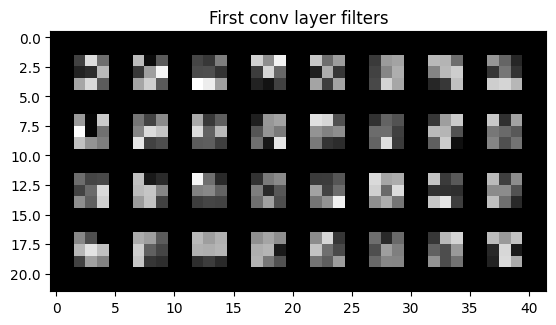

In [28]:
plot_conv1_filters()

For first convolution layer we have 32 - 3x3x1 filters or simply 32 - 3x3 filters.<br>
**Observations:**
1. From above plots we can observe that some of the filters(for eg. filter-2,3,4,5,6,9,10,11,13,16,20,31 ) are trying to detect horizontal or vertical edges.
2. Some of the filters are having dark or white patch in the centre pixel and white or dark in rest of the pixels respectively are performing sharpening operation.
3. Some filters are performing smoothening operation.

**2. Plot filters of a higher layer and compare them with conv1 layer filters.**

In [29]:
def plot_higher_layer_filters():
    #only higher layer we have is second conv layer
    filter2 = model.layer2[0].weight.detach().clone()
    if (device == torch.device("cuda")):
        filter2 = filter2.cpu()
    filter2 = filter2 - filter2.min()
    filter2 = filter2/filter2.max()
    filter_indices = np.random.randint(0 , 31, 5) #choose random 5 filters to plot
    for indices in filter_indices:    
        image = make_grid(filter2[indices].reshape(32,1,3,3))
        image = image.permute(1,2,0) 
        #plotting the second layer filters
        plt.imshow(image)
        str_title = 'Second Convolutional Layer filters for Filter no: ' + str(indices)
        plt.title(str_title)
        plt.show()

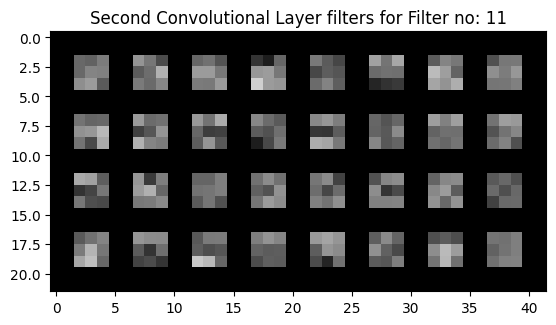

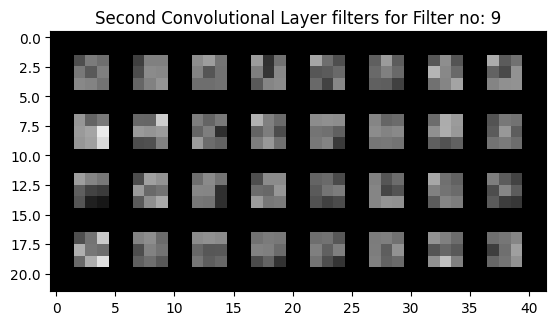

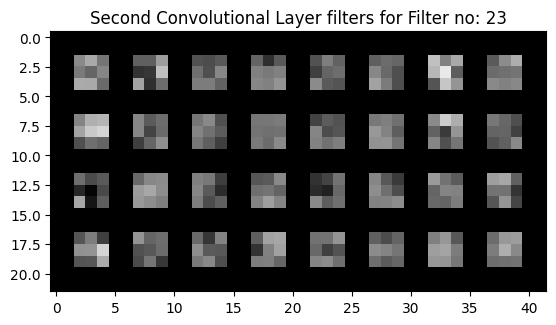

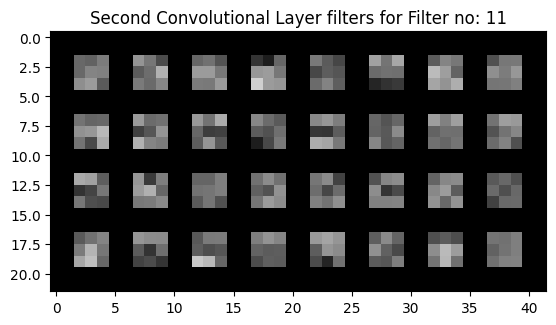

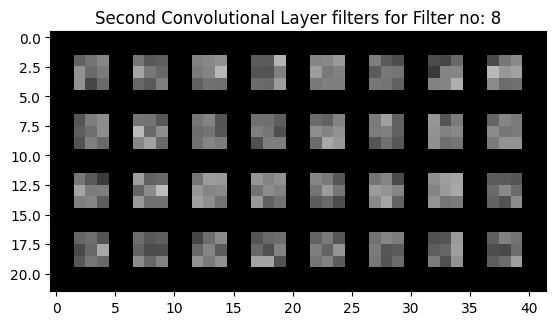

In [30]:
plot_higher_layer_filters()

For the second convolution layer, we have 32 - 3x3x32 filters, as it is difficult to plot all filters, plotting some randomly selected filters. We can see that most of the filters have similar patches around certain regions, which may indicate that they are trying to find similar features. Unlike the first convolution layer filters, the interpretation of what the second convolution layer filters are trying to perform is unclear. 

**3. Visualize the activations of the convolutional layers. What do you observe as you go deeper?**

In [31]:
def Visualize_activations(): 
    list_of_indices = np.random.randint(low=0, high=9999, size=3)
    for index in list_of_indices:
        test_image = test_loader.dataset.data[index, :, :].clone()
    with torch.no_grad():
        if(device == torch.device("cuda")): 
            test_image = test_image.reshape(1,1,28,28).cuda().float() #reshaping the image into 28x28 pixels
        else:
            test_image = test_image.reshape(1,1,28,28).float()
        conv1_FM = model.layer1[0].forward(test_image).reshape(32,1,28,28).cpu() #we take the featuremaps obtained at the output of conv1

        #normalizing the feature maps 
        conv1_FM -= conv1_FM.min() 
        conv1_FM /= conv1_FM.max()
        image = make_grid(conv1_FM)         
        image = image.permute(1,2,0) #permuting the dimensions of the tensor grid as for tensors CxWxH

        #plotting the first layer feature maps
        plt.imshow(image)
        plt.title('Feature maps after the first Convolutional Layer')
        plt.show()

    with torch.no_grad():

        conv2_FM = model.layer1.forward(test_image)
        conv2_FM = model.layer2[0].forward(conv2_FM).reshape(32,1,14,14).cpu() #we take the featuremaps obtained at the output of conv2
        #normalizing the feature maps
        conv2_FM -= conv2_FM.min() 
        conv2_FM /= conv2_FM.max() 
        image = make_grid(conv2_FM)         
        image = image.permute(1,2,0) #permuting the dimensions of the tensor grid as for tensors CxWxH

        #plotting the second layer feature maps
        plt.imshow(image)
        plt.title('Feature maps after the second Convolutional Layer')
        plt.show()

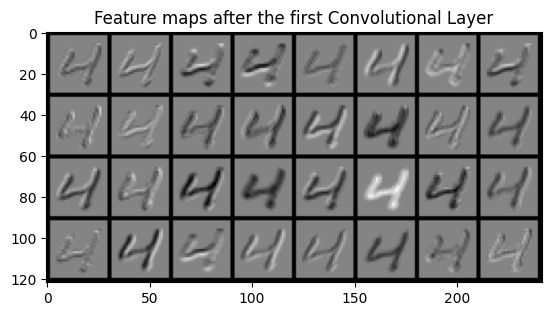

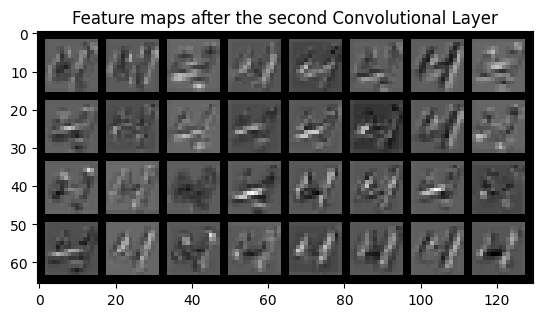

In [32]:
Visualize_activations()

1. From the activation outputs of layer1, it can be observed that the edges of the digits are dark for some and light for some, and almost all looks either sharpened or smoothened. The output images resemble the digits more clearly.
2. From the activation outputs of layer2, it can be observed that the actual resemblance of input digits is still there but less compared to layer1. It can be observed that dark and light patches are present in some regions indicating that they are trying to learn similar features.

**4. Occluding parts of the image :** 
Suppose that the network classifies an image of a digit successfully. How can we
    be certain that it is actually observing the main part of the digit in the image as opposed to background or something
    else? One way of investigating this is by plotting the probability of the class of interest as a function of the position of an occluder object. Pick any 10 random images and occlude parts of the images iteratively with a patch (e.g. a grey
    patch). Observe the probability of the class of interest and plot the probability in a grid as a function of the patch
    position. (You can use x axis and y axis to denote the position of the patch in xy plane, and plot the probability as
    intensity). Based on this experiment, report if the learning meaningful or not

In [33]:
#considering occlusion patch size as 14(after performing experiments with different sizes, 14 has been choosen) and occlusion pixel as 0.5
def occluded_image(x,i,j,occ_patch_size=14,occ_pixel=0.5):
    y = x.copy()
    y[i:i+occ_patch_size,j:j+occ_patch_size] = occ_pixel #occlude the image within this location
    return y

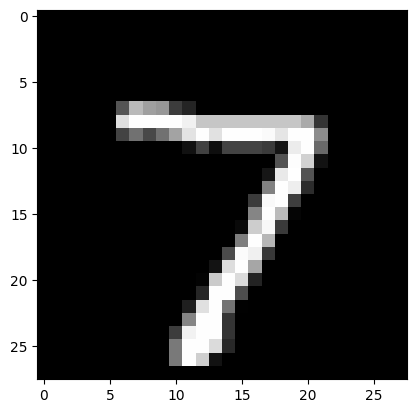

Figure:7, True label:7, Probability:1.0000, Predicted label:7
Figure:7, True label:7, Probability:0.9828, Predicted label:7
Figure:7, True label:7, Probability:1.0000, Predicted label:7
Figure:7, True label:7, Probability:0.9995, Predicted label:7
Figure:7, True label:7, Probability:0.9467, Predicted label:7
Figure:7, True label:7, Probability:1.0000, Predicted label:7
Figure:7, True label:7, Probability:0.9963, Predicted label:7
Figure:7, True label:7, Probability:0.9523, Predicted label:7
Figure:7, True label:7, Probability:1.0000, Predicted label:7


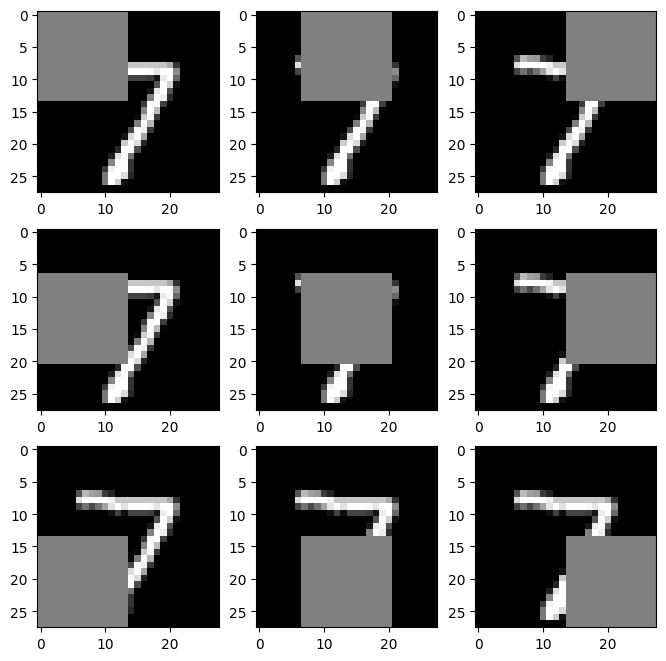

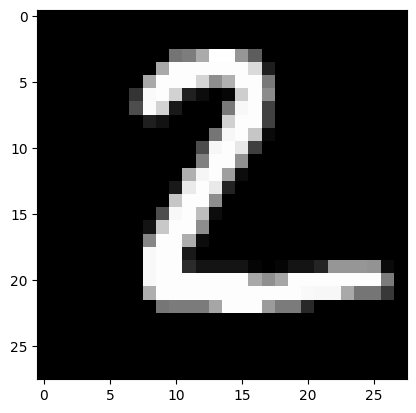

Figure:2, True label:2, Probability:1.0000, Predicted label:2
Figure:2, True label:2, Probability:0.9808, Predicted label:2
Figure:2, True label:2, Probability:1.0000, Predicted label:2
Figure:2, True label:2, Probability:0.9856, Predicted label:2
Figure:2, True label:2, Probability:0.9930, Predicted label:2
Figure:2, True label:2, Probability:1.0000, Predicted label:2
Figure:2, True label:2, Probability:0.9949, Predicted label:2
Figure:2, True label:2, Probability:1.0000, Predicted label:2
Figure:2, True label:2, Probability:1.0000, Predicted label:2


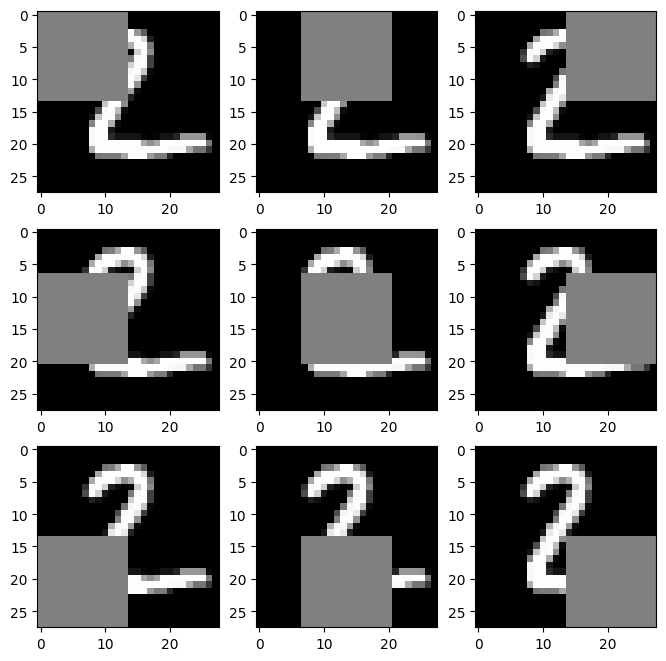

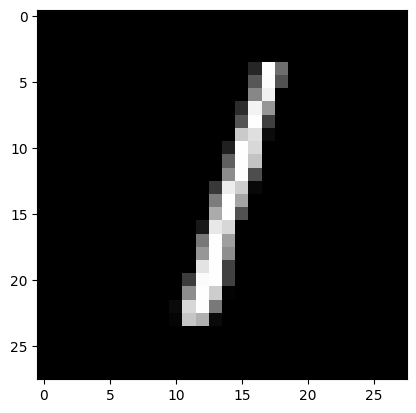

Figure:1, True label:1, Probability:0.5180, Predicted label:1
Figure:1, True label:1, Probability:0.0051, Predicted label:8
Figure:1, True label:1, Probability:0.9060, Predicted label:1
Figure:1, True label:1, Probability:0.8098, Predicted label:1
Figure:1, True label:1, Probability:0.0155, Predicted label:4
Figure:1, True label:1, Probability:0.9732, Predicted label:1
Figure:1, True label:1, Probability:0.9781, Predicted label:1
Figure:1, True label:1, Probability:0.0003, Predicted label:2
Figure:1, True label:1, Probability:0.9191, Predicted label:1


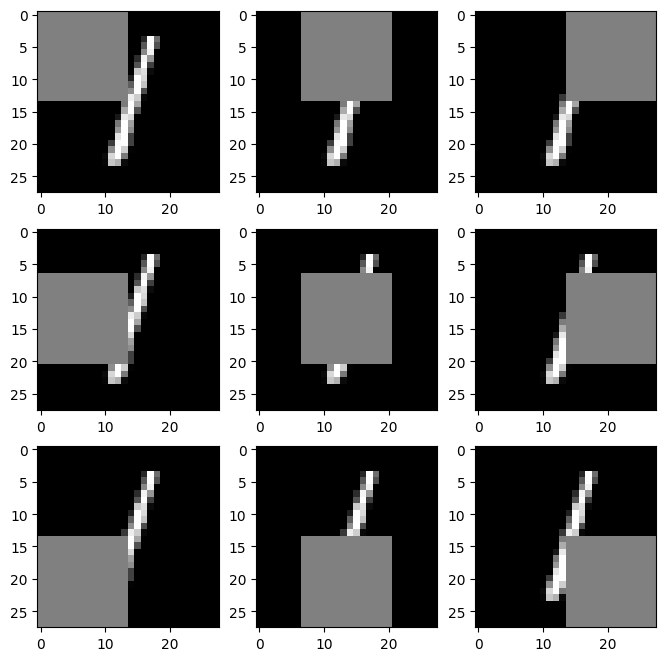

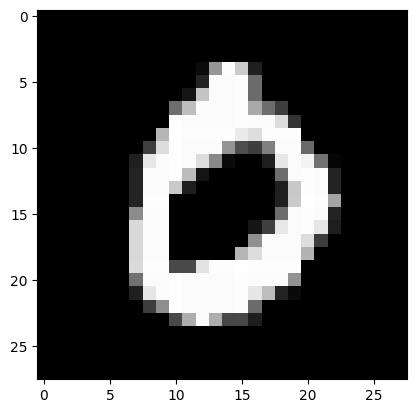

Figure:0, True label:0, Probability:0.9997, Predicted label:0
Figure:0, True label:0, Probability:0.8178, Predicted label:0
Figure:0, True label:0, Probability:0.9980, Predicted label:0
Figure:0, True label:0, Probability:0.9982, Predicted label:0
Figure:0, True label:0, Probability:0.9134, Predicted label:0
Figure:0, True label:0, Probability:0.9987, Predicted label:0
Figure:0, True label:0, Probability:0.3799, Predicted label:7
Figure:0, True label:0, Probability:0.0242, Predicted label:7
Figure:0, True label:0, Probability:0.9985, Predicted label:0


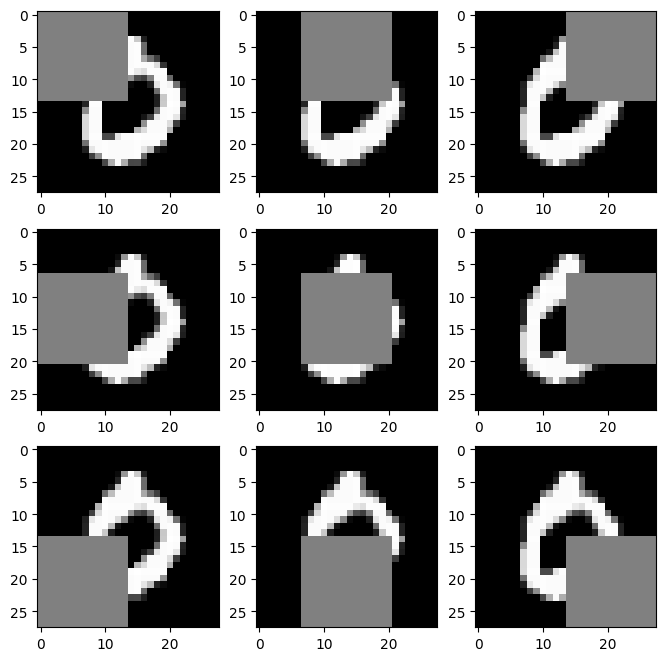

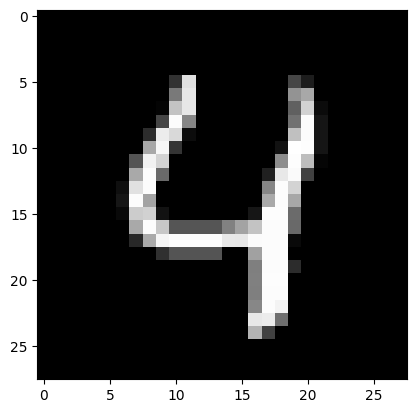

Figure:4, True label:4, Probability:1.0000, Predicted label:4
Figure:4, True label:4, Probability:0.7633, Predicted label:4
Figure:4, True label:4, Probability:0.9999, Predicted label:4
Figure:4, True label:4, Probability:0.9998, Predicted label:4
Figure:4, True label:4, Probability:0.4395, Predicted label:4
Figure:4, True label:4, Probability:0.9819, Predicted label:4
Figure:4, True label:4, Probability:0.9993, Predicted label:4
Figure:4, True label:4, Probability:0.3427, Predicted label:8
Figure:4, True label:4, Probability:1.0000, Predicted label:4


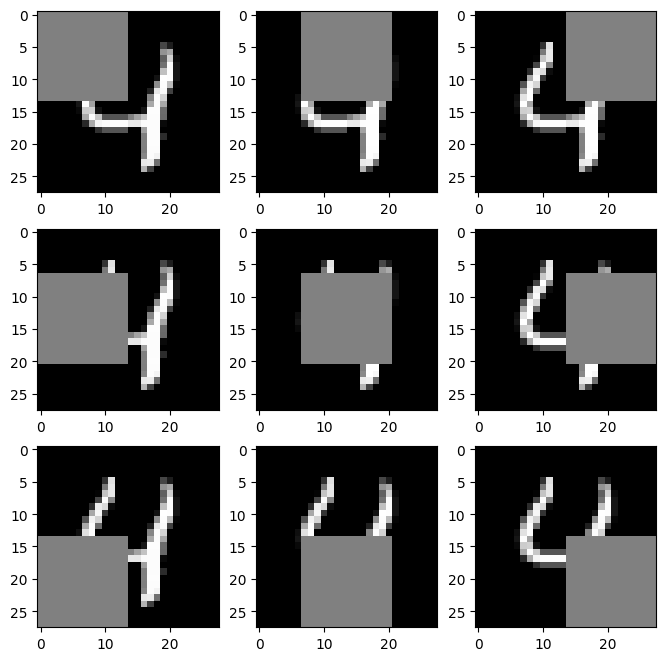

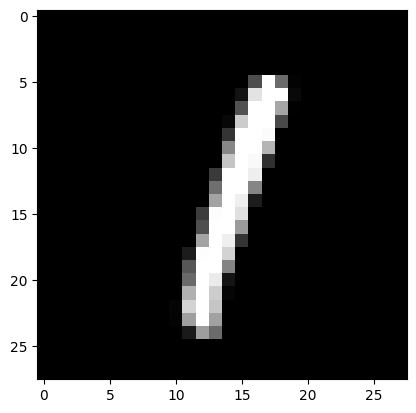

Figure:1, True label:1, Probability:0.6023, Predicted label:1
Figure:1, True label:1, Probability:0.0029, Predicted label:7
Figure:1, True label:1, Probability:0.9062, Predicted label:1
Figure:1, True label:1, Probability:0.8154, Predicted label:1
Figure:1, True label:1, Probability:0.0019, Predicted label:7
Figure:1, True label:1, Probability:0.9496, Predicted label:1
Figure:1, True label:1, Probability:0.9880, Predicted label:1
Figure:1, True label:1, Probability:0.0022, Predicted label:2
Figure:1, True label:1, Probability:0.7052, Predicted label:1


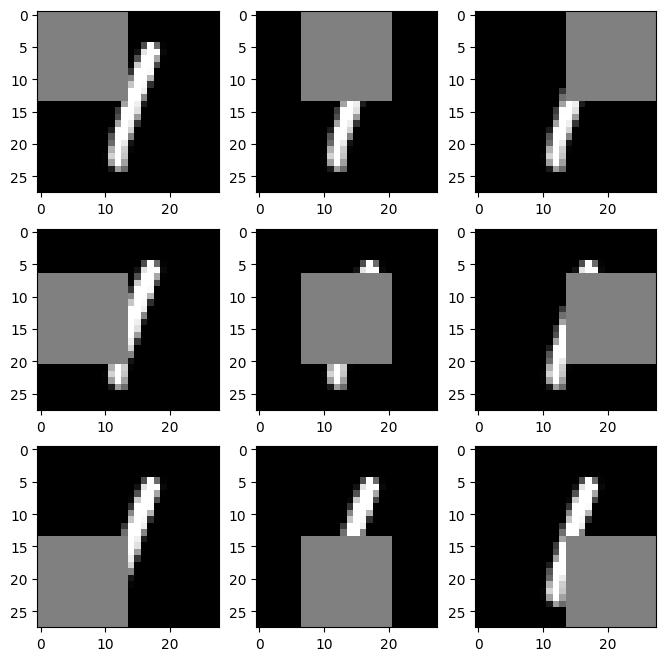

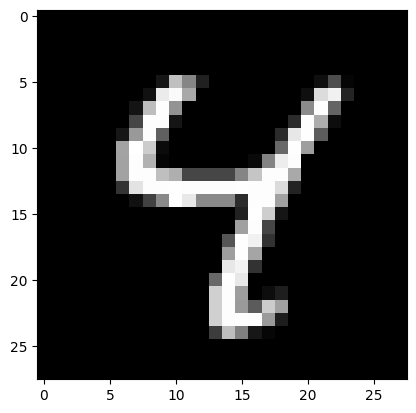

Figure:4, True label:4, Probability:0.9999, Predicted label:4
Figure:4, True label:4, Probability:0.9913, Predicted label:4
Figure:4, True label:4, Probability:0.9996, Predicted label:4
Figure:4, True label:4, Probability:0.9994, Predicted label:4
Figure:4, True label:4, Probability:0.7445, Predicted label:4
Figure:4, True label:4, Probability:0.9932, Predicted label:4
Figure:4, True label:4, Probability:0.9832, Predicted label:4
Figure:4, True label:4, Probability:0.3652, Predicted label:8
Figure:4, True label:4, Probability:1.0000, Predicted label:4


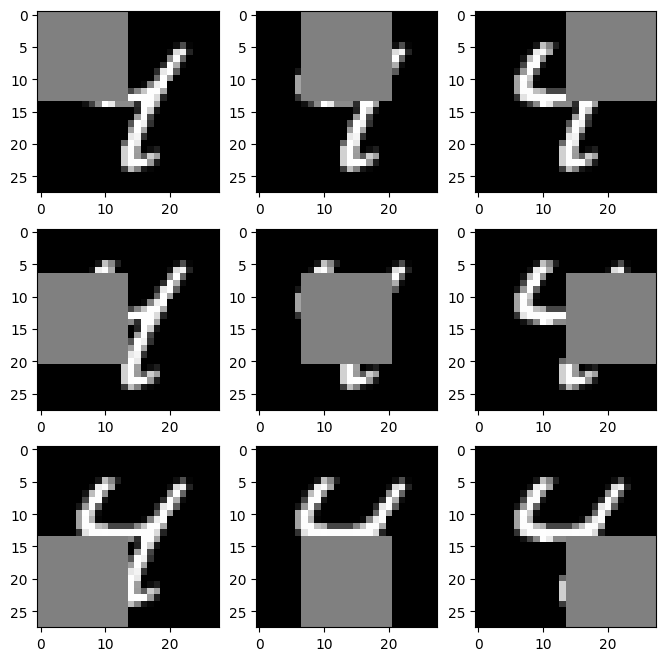

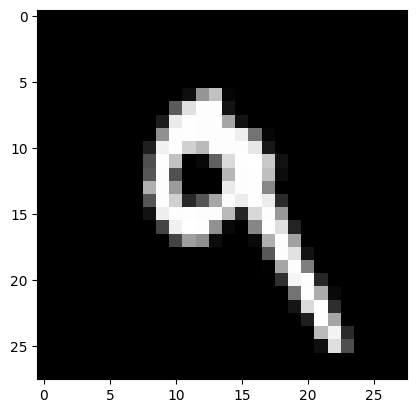

Figure:9, True label:9, Probability:0.1274, Predicted label:4
Figure:9, True label:9, Probability:0.0005, Predicted label:4
Figure:9, True label:9, Probability:0.0293, Predicted label:4
Figure:9, True label:9, Probability:0.8700, Predicted label:9
Figure:9, True label:9, Probability:0.9041, Predicted label:9
Figure:9, True label:9, Probability:0.9984, Predicted label:9
Figure:9, True label:9, Probability:0.9579, Predicted label:9
Figure:9, True label:9, Probability:0.8822, Predicted label:9
Figure:9, True label:9, Probability:0.9972, Predicted label:9


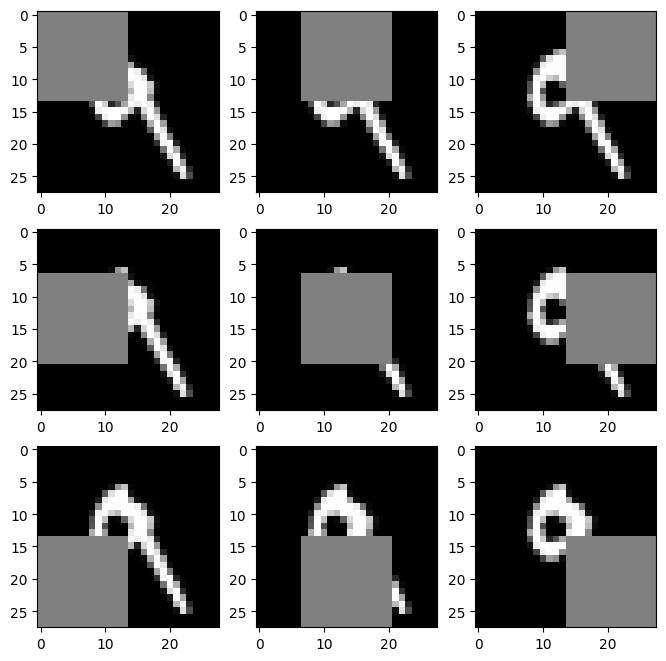

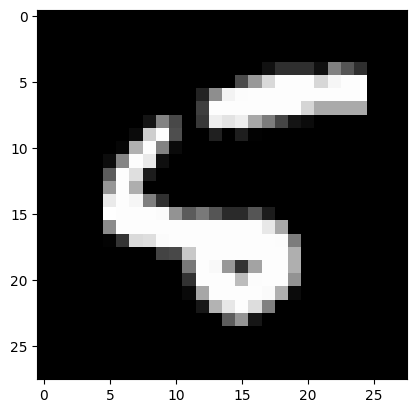

Figure:5, True label:5, Probability:0.9953, Predicted label:5
Figure:5, True label:5, Probability:0.5508, Predicted label:5
Figure:5, True label:5, Probability:0.1080, Predicted label:8
Figure:5, True label:5, Probability:0.9768, Predicted label:5
Figure:5, True label:5, Probability:0.1914, Predicted label:0
Figure:5, True label:5, Probability:0.1425, Predicted label:8
Figure:5, True label:5, Probability:0.9793, Predicted label:5
Figure:5, True label:5, Probability:0.8708, Predicted label:5
Figure:5, True label:5, Probability:0.9894, Predicted label:5


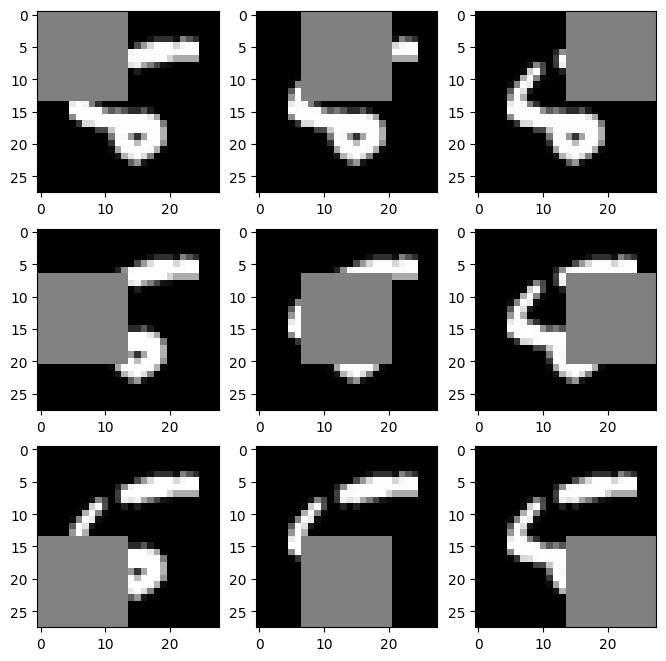

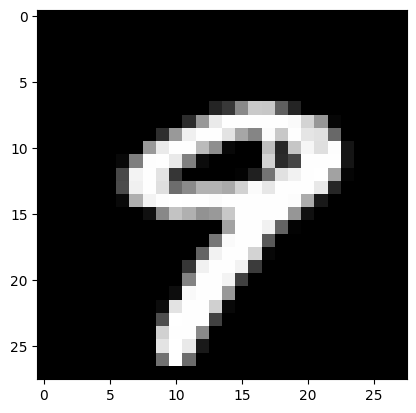

Figure:9, True label:9, Probability:0.9961, Predicted label:9
Figure:9, True label:9, Probability:0.0001, Predicted label:4
Figure:9, True label:9, Probability:0.0012, Predicted label:4
Figure:9, True label:9, Probability:0.9205, Predicted label:9
Figure:9, True label:9, Probability:0.0103, Predicted label:7
Figure:9, True label:9, Probability:0.7710, Predicted label:9
Figure:9, True label:9, Probability:0.9945, Predicted label:9
Figure:9, True label:9, Probability:0.7129, Predicted label:9
Figure:9, True label:9, Probability:0.9961, Predicted label:9


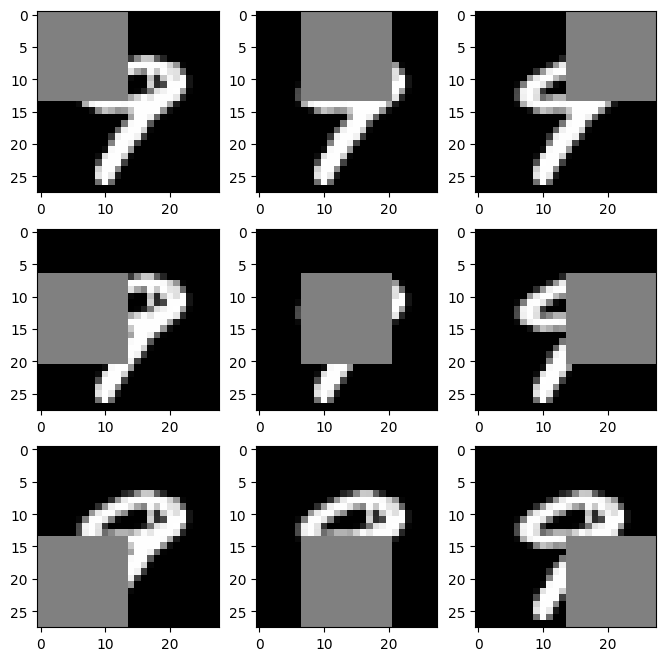

In [77]:
loader_test = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1,shuffle=False)
count = 0
for images,labels in loader_test:
    images = images.to(device)
    labels = labels.to(device)
    img = images.cpu().numpy().reshape(28,28)
    plt.imshow(img,cmap='gray')
    plt.show()

    fig = plt.figure(figsize=(8,8))
    col,row = 3,3
    #occlude each image with occ_patch pixel value at a given location
    for i in range(1,10):
        fig.add_subplot(row,col,i)
        occ_image = occluded_image(img,7*int((i-1)/3),7*((i-1)%3))
        plt.imshow(occ_image,cmap='gray')
        image = torch.from_numpy(occ_image.reshape(1,1,28,28))
        image = image.to(device)
        preds = model(image)
        for i in labels.cpu().numpy():
            idx = i

        pred_ = preds.data.cpu().numpy()
        predicted = np.argmax(pred_)
        pred_ = np.exp(pred_)/np.sum(np.exp(pred_))
        print('Figure:{}, True label:{}, Probability:{:.4f}, Predicted label:{}'.format(i,idx,pred_[0,idx],predicted))

    plt.show()
    count += 1
    if count == 10:
        break

For the occlusion experiment a patch size of 14x14 (after experimenting with different patch-sizes this was considered as it was giving posssibility of occluding different parts of digits)<br>
***Observations:***
1. If the image is occluded in the region where the digit is not present or only very few pixels are present, then the predictions are correct with high probability.
2. If the image is occluded in the centre region or where a significant part of the digit is present, then the predictions are wrong if important number queues are missing, like loops and horizontal and vertical bars.

# 3. Adversarial Examples

### 3.1. Non-Targeted Attack
The idea is to generate an image that is designed to make the neural network produce a certain output. Initialize a matrix to be the same size of an MNIST image with Gaussian noise centered around 128. Let this matrix be X. Beginning with this noise matrix, try to maximize the probability of this matrix to be categorized as some target class. Here target class can take values between 0 to 9. Define the cost function as :<br>
    \begin{align}
    C = logits[targetClass] 
    \end{align}
 where logits is the network output before final softmax operation. Find the derivatives (d) of the cost function with  respect to the input x using backpropagation. Now, set<br>
     \begin{align}
    X = X + stepsize × d 
        \end{align}
    This essentially tries to increase the target class score by gradient ascent.
    

In [78]:
from torch.autograd import Variable
target_classes = [0,1,2,3,4,5,6,7,8,9]
step_size = 0.1
def non_targeted_attack(digit):
    X = np.random.normal(loc=128,scale=10,size=(28,28)) #Initializing a 28x28 matrix with gaussian noise 1ith mean = 128, std=10
    #converting X to Tensor
    if(device==torch.device("cuda")):
        X = torch.from_numpy(X).reshape(1,1,28,28).cuda().float()
    else:
        X = torch.from_numpy(X).reshape(1,1,28,28).float()
    logits=[]
    for step in range(1000):
        X = Variable(X,requires_grad=True) #wrapping tensor X into a variable 
        out = model_with_bn.layer1.forward(X)
        out = model_with_bn.layer2.forward(out)
        out = out.reshape(out.size(0), -1)
        out = model_with_bn.layer3.forward(out)
        out = model_with_bn.layer4.forward(out)
        #cost function output of layer4 before applying softmax
        loss = out[:, digit]
        loss_value = loss.cpu().detach().numpy()
        logits.append(loss_value)
#         if(step%10==0):
#             print(f"Digit to generate : {digit}\tStep : {step}\tLoss value : {loss_value}")
        loss.backward(retain_graph=True)
        d = torch.sign(X.grad.data) #derivative of loss wrt X
        X = X+step_size*d
    plt.plot(np.asfarray(logits))
    plt.title(f"Cost function for {digit}")
    plt.show()
    #plot the generated adverserial image
    gen_img_tensor = X
    gen_img = X.cpu().reshape(28,28).detach().numpy()
    gen_img = gen_img - np.min(gen_img)
    gen_img = gen_img/np.max(gen_img)
    plt.imshow(gen_img,cmap='gray')
    plt.colorbar()
    plt.title(f"Adversarial image generated for {digit}")
    plt.show()
    return gen_img_tensor


    

**1. Show the generated image for each of the MNIST classes?**

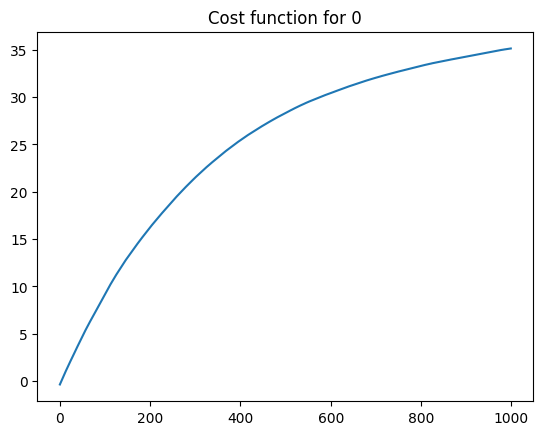

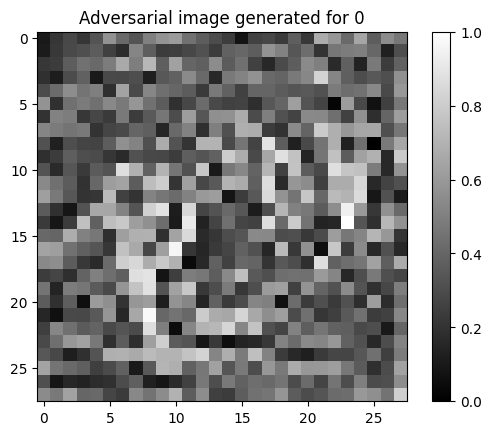

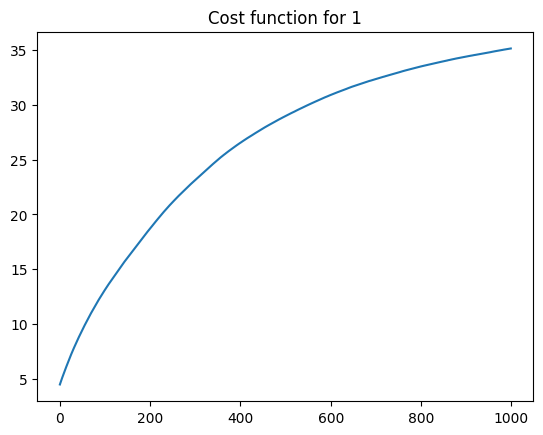

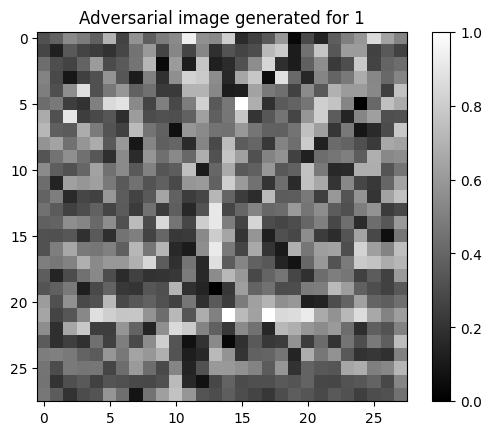

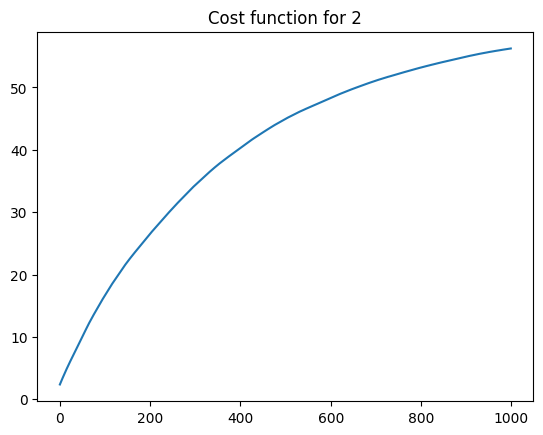

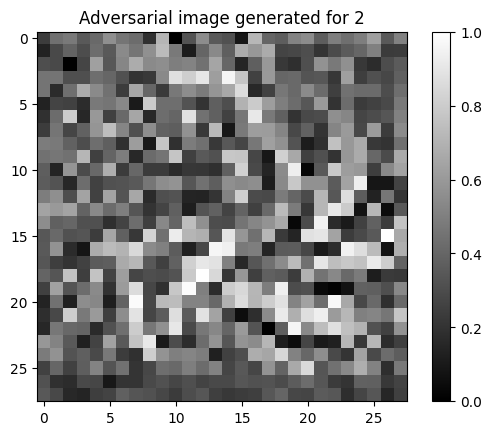

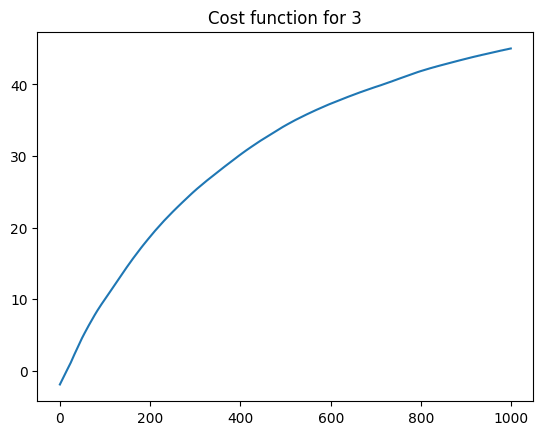

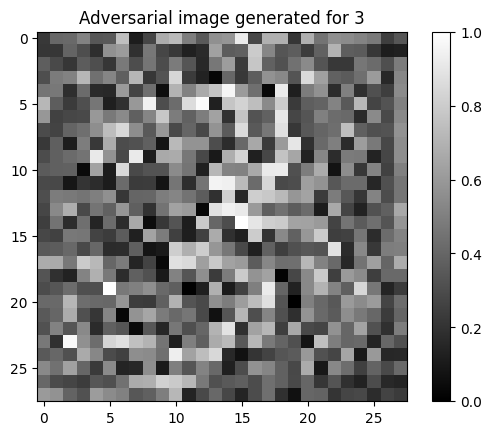

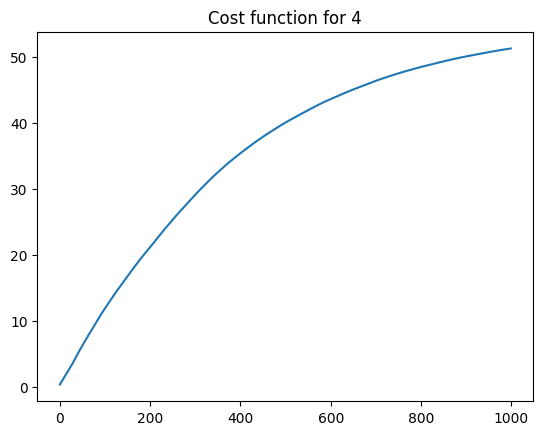

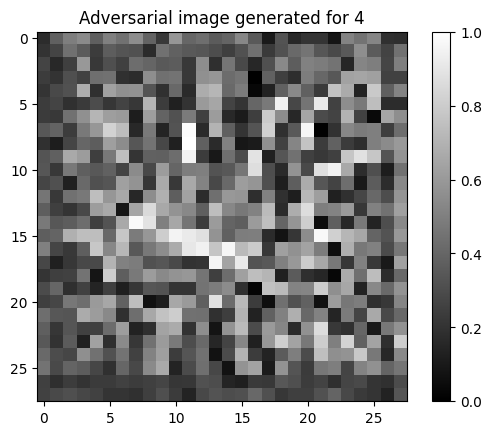

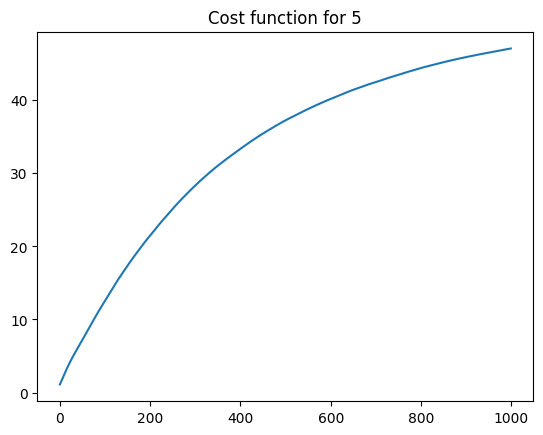

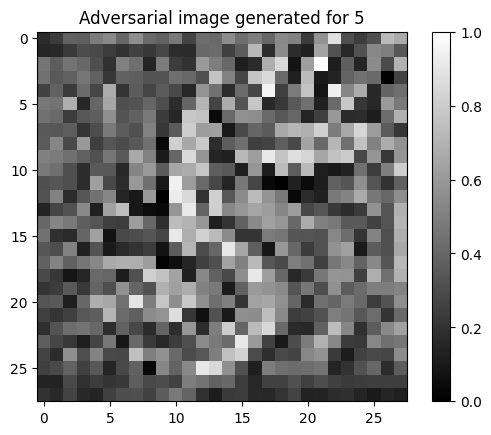

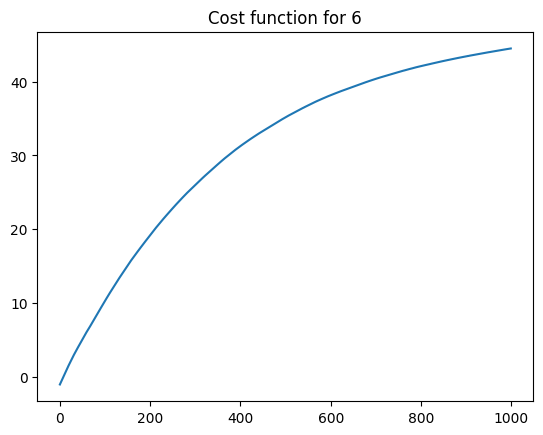

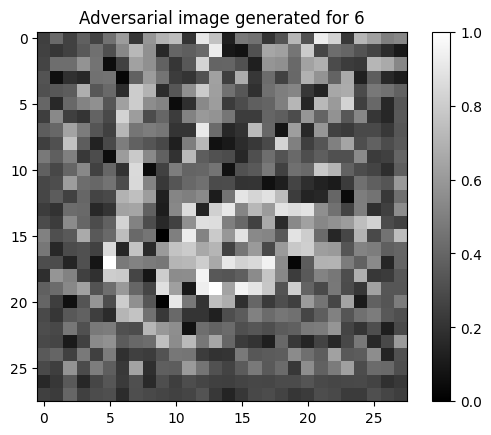

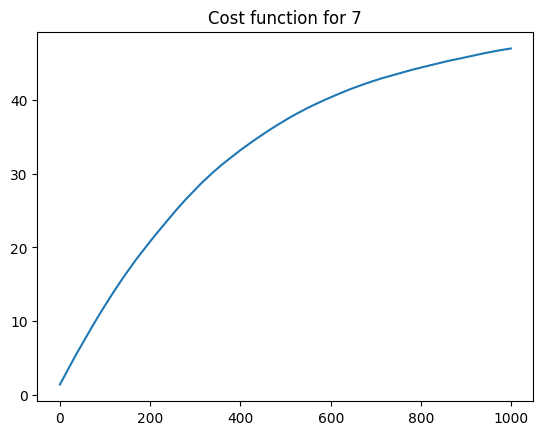

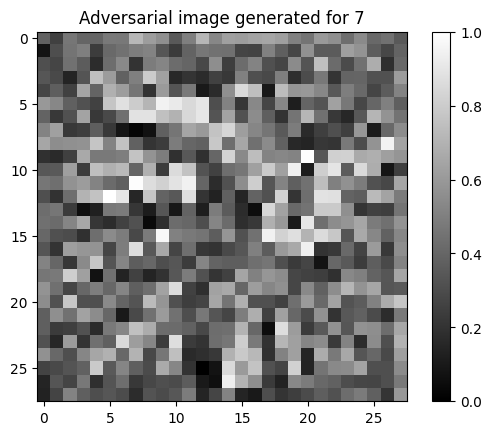

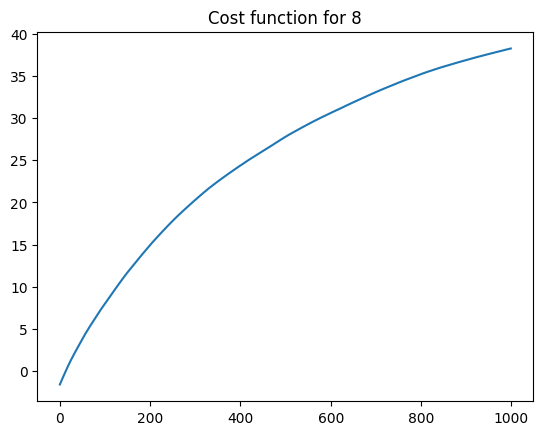

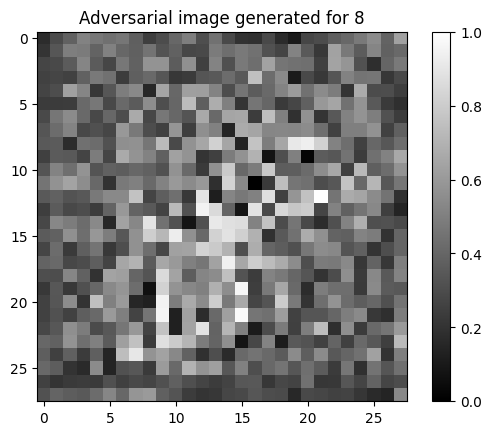

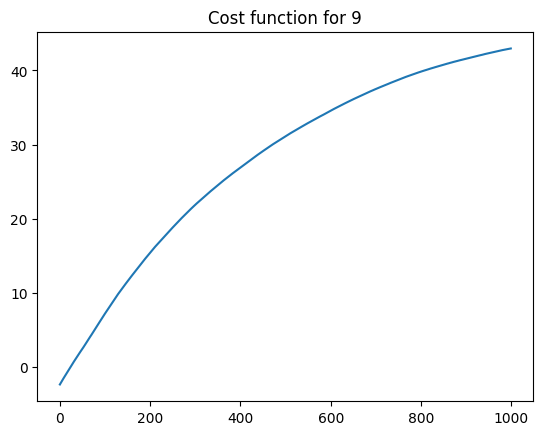

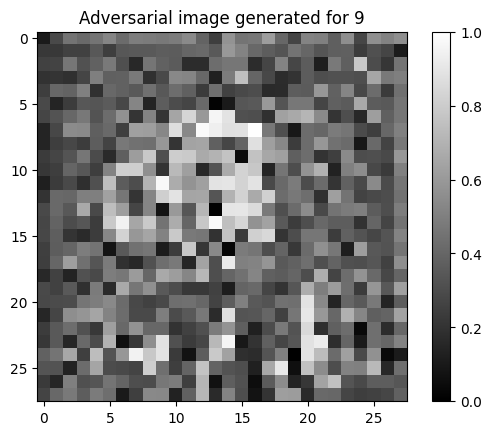

In [79]:
target_classes = [0,1,2,3,4,5,6,7,8,9]
gen_imgs_non_targeted_attack = []
for i in range(0,len(target_classes)):
    gen_imgs_non_targeted_attack.append(non_targeted_attack(i))


**2. Do the generated images look like a number? If not, can you think of some reason?**<br>
   No, the generated images doesnt look like the actual digits but there are some key patterns for generated images corresponding to each digit such as: <br>
   we can observe a loop in digits 6,8,9 and vertical bar in digits 1,7,9<br>
   

**3. Plot the cost function. Is it increasing or decreasing?**<br>
    The cost function is increasing

Prediction of Generated Adverserial Image for digit 0


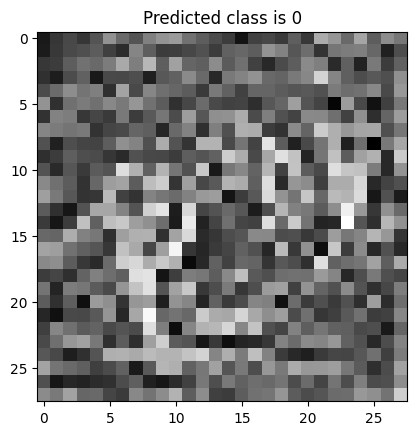

Prediction of Generated Adverserial Image for digit 1


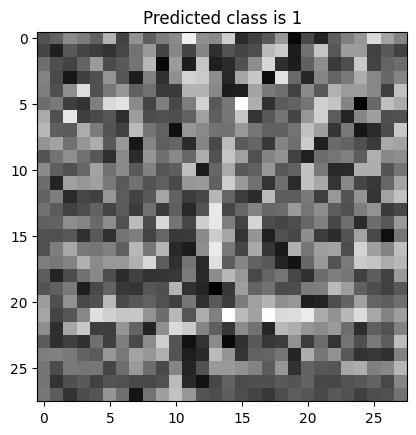

Prediction of Generated Adverserial Image for digit 2


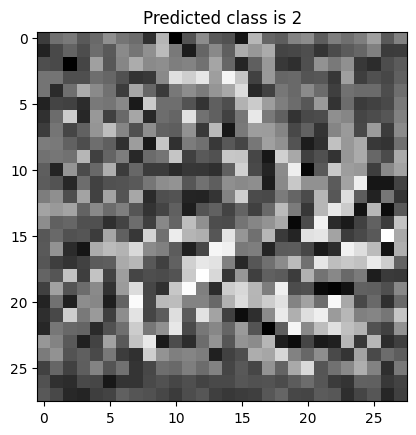

Prediction of Generated Adverserial Image for digit 3


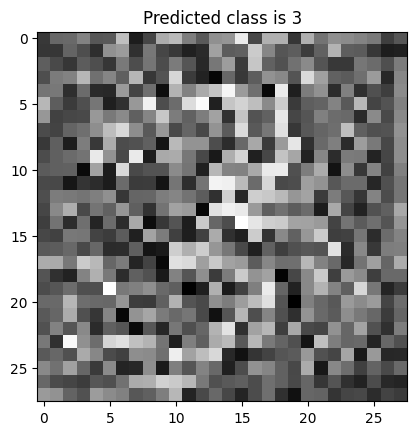

Prediction of Generated Adverserial Image for digit 4


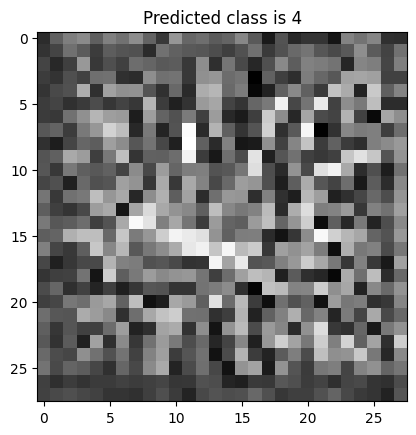

Prediction of Generated Adverserial Image for digit 5


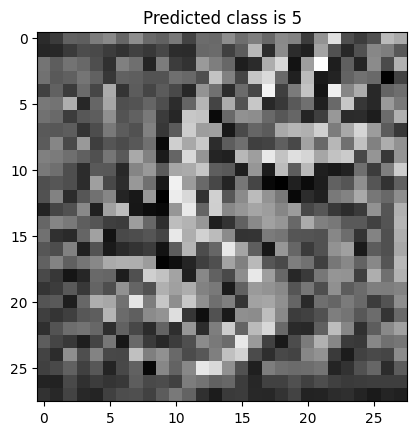

Prediction of Generated Adverserial Image for digit 6


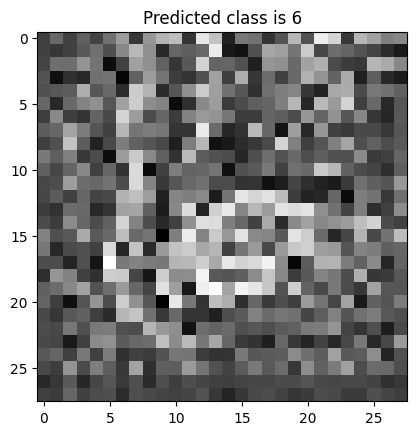

Prediction of Generated Adverserial Image for digit 7


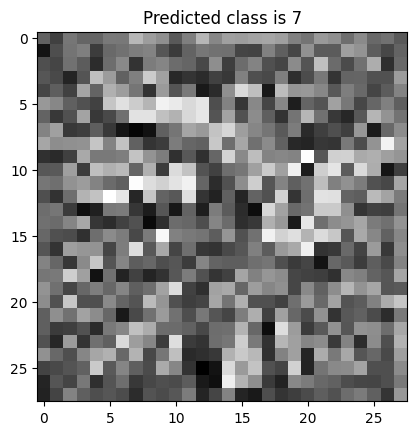

Prediction of Generated Adverserial Image for digit 8


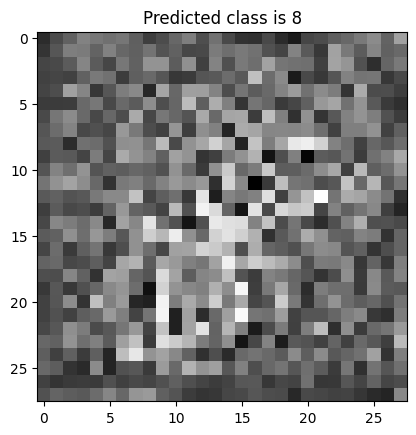

Prediction of Generated Adverserial Image for digit 9


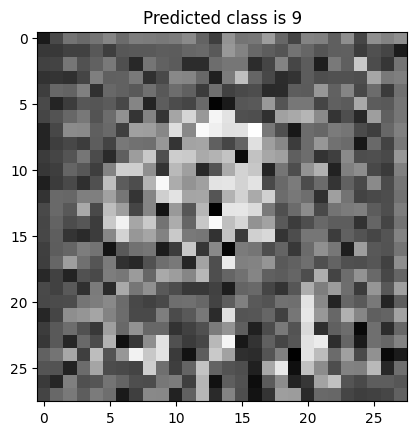

In [80]:
target_classes = [0,1,2,3,4,5,6,7,8,9]
for i in range(0,len(target_classes)):
    print("Prediction of Generated Adverserial Image for digit",i)
    predict(gen_imgs_non_targeted_attack[i])

**4. Is the network always predicting targetClass with high confidence for the generated images?**<br>
  Yes, as we can see the predictions for generated images above, the network is predicting the target class correctly with high confidence.

### 3.2 Targeted Attack
 Can we generate some adversarial example that looks like a particular digit, but the network will classify it as something else? For example, can we generate an image of digit 2, which the network will classify as 5? For this,change the cost function to: <br>
    \begin{align}
        C = logits[targetClass] − β ×MSE(generatedImage, targetImage) 
    \end{align}
    <br>
    where target Image is what we want our adversarial example to look like and β is very small (e.g. 0.001, tune it according to the output). We are trying to increase the target class score for the generated image, but also want the generated image to look like some target image (by minimizing the MSE). Find the derivatives of the cost function with respect to the input x using backpropagation. Now, set<br>
    \begin{align}
    X = X + stepsize × d
    \end{align}
    <br>
   
    
    

In [81]:
# Targeted attack
beta = 0.001
def targeted_attack(in_digit,out_digit):
    target_image = test_loader.dataset.data[in_digit, :,:].clone().reshape(1,1,28,28).cuda().float()
    out = model_with_bn.forward(target_image).detach().cpu().numpy()
    label = np.argmax(out)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(target_image.cpu().reshape(28,28).numpy(),cmap='gray')
    axarr[0].set_title(f"Target Image of {label}")
    X = np.random.normal(loc=128, scale=10, size=(28,28))
    if (device==torch.device("cuda")):
        X = torch.from_numpy(X).reshape(1,1,28,28).cuda().float()
    else:
        X = torch.from_numpy(X).reshape(1,1,28,28).float()
    for step in range(1000):
        X = Variable(X, requires_grad=True)
        out = model_with_bn.layer1.forward(X)
        out = model_with_bn.layer2.forward(out)
        out = out.reshape(out.size(0), -1)
        out = model_with_bn.layer3.forward(out)
        out = model_with_bn.layer4.forward(out)
        probablities = F.softmax(out, dim=1)
        to_be_predicted_class_probablity = probablities[:,out_digit].cpu().detach().numpy()
        Logit = out[:, out_digit]
        mse_error = F.mse_loss(X, target_image)
        mse_error_to_print = (mse_error.cpu().detach().numpy())
        loss = Logit - beta*mse_error
#         if (step%10==0):
#             print(f"Step : {step}\t p(classification) : {to_be_predicted_class_probablity}\tMSE : {mse_error_to_print}")
        loss.backward(retain_graph=True)
        d = torch.sign(X.grad.data)
        X = X+step_size*d
#     print(f"Step : {step}\t p(classification) : {to_be_predicted_class_probablity}\tMSE : {mse_error_to_print}")
    gen_img_tensor = X
    gen_img = X.cpu().reshape(28,28).detach().numpy()
    gen_img = gen_img - np.min(gen_img)
    gen_img = gen_img/np.max(gen_img)
    axarr[1].imshow(gen_img,cmap='gray')
    axarr[1].set_title(f"Generated image of {label}")
    plt.show()
    return gen_img_tensor

**1. Show the generated image for each of the MNIST classes**

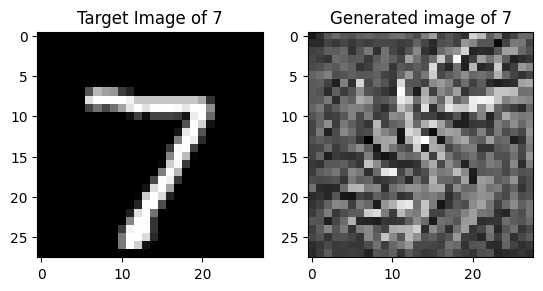

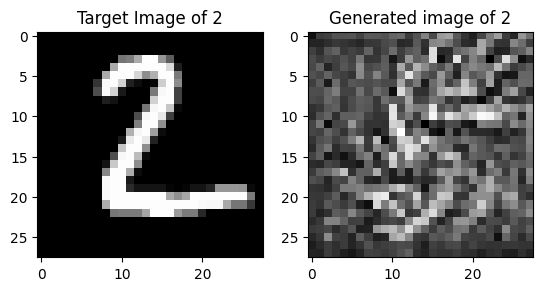

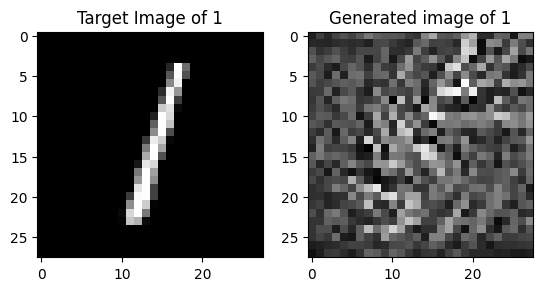

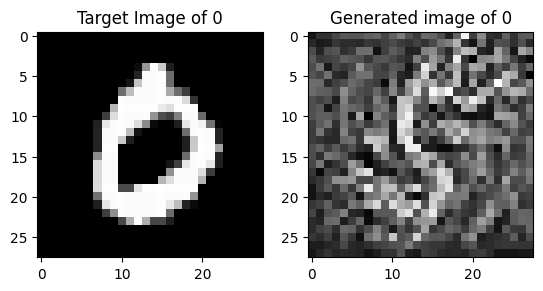

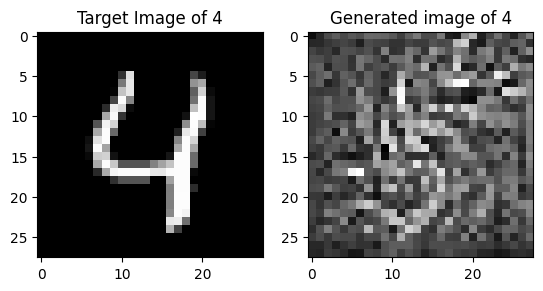

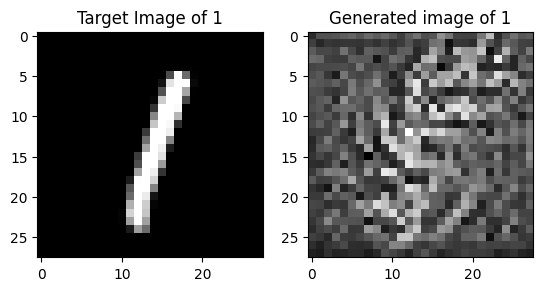

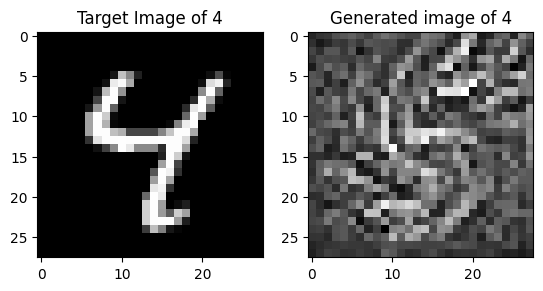

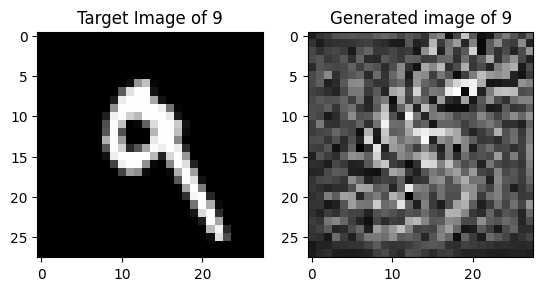

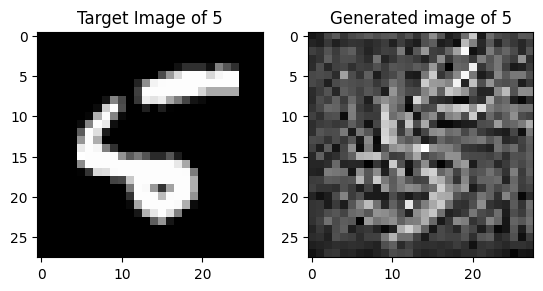

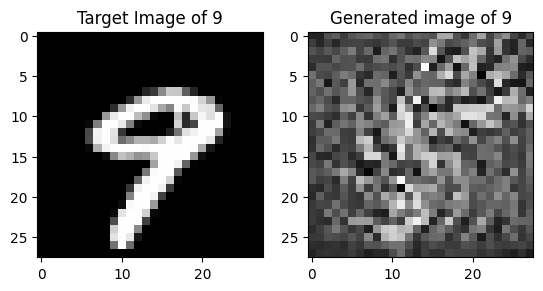

In [82]:
target_classes = [0,1,2,3,4,5,6,7,8,9]
gen_imgs_targeted_attack = []
for i in range(0,len(target_classes)):
    gen_imgs_targeted_attack.append(targeted_attack(i,5))

Prediction of Generated Adverserial Image for digit 0


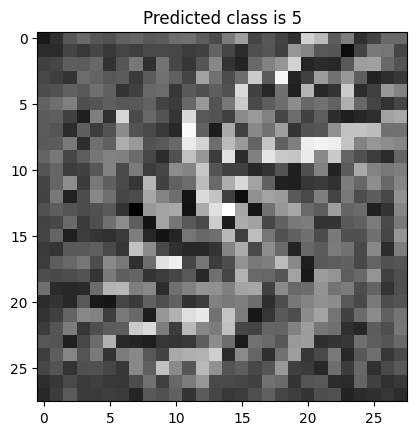

Prediction of Generated Adverserial Image for digit 1


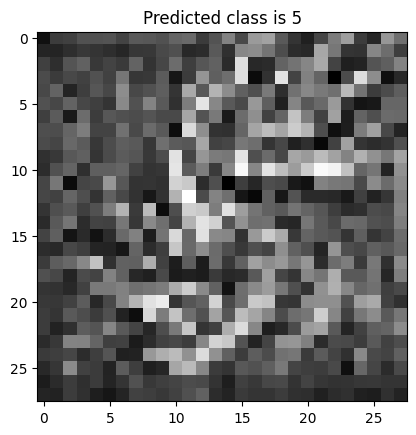

Prediction of Generated Adverserial Image for digit 2


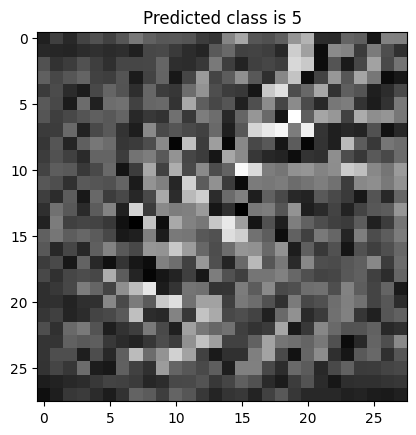

Prediction of Generated Adverserial Image for digit 3


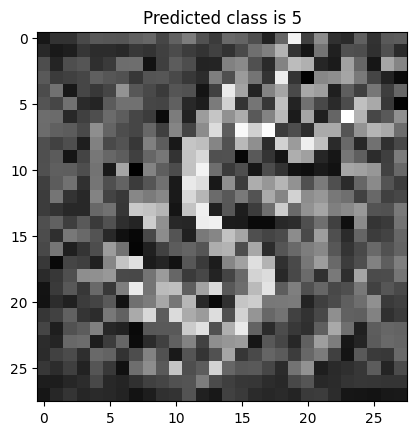

Prediction of Generated Adverserial Image for digit 4


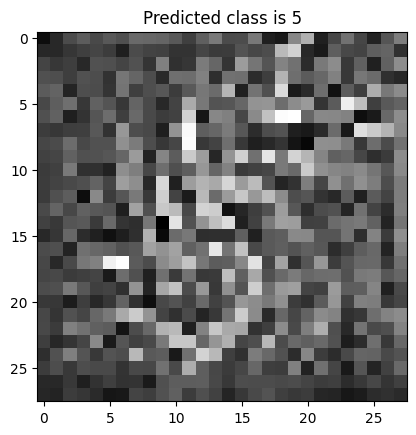

Prediction of Generated Adverserial Image for digit 5


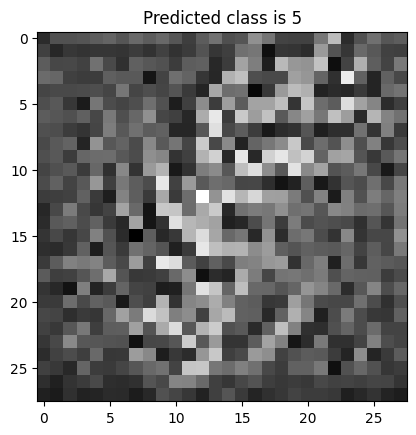

Prediction of Generated Adverserial Image for digit 6


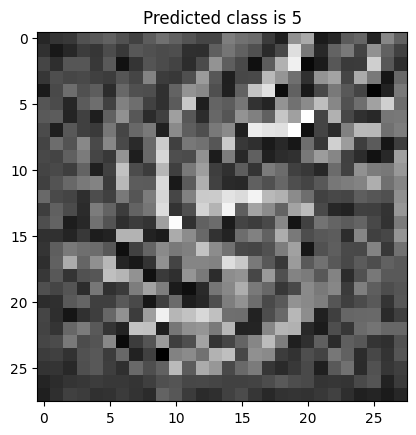

Prediction of Generated Adverserial Image for digit 7


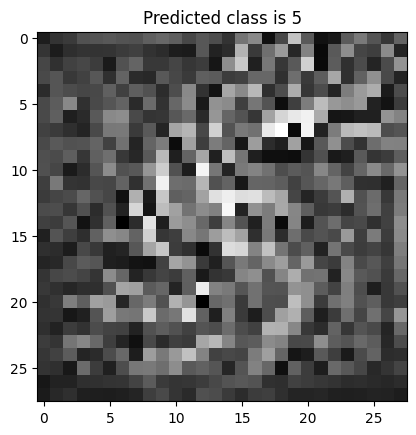

Prediction of Generated Adverserial Image for digit 8


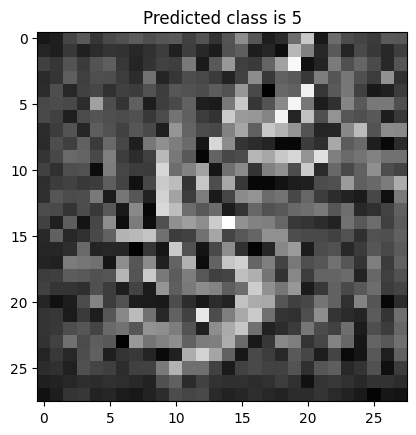

Prediction of Generated Adverserial Image for digit 9


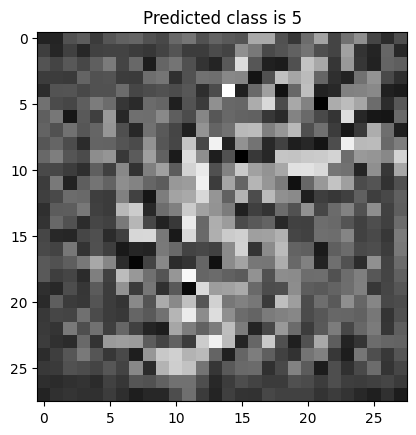

In [83]:
target_classes = [0,1,2,3,4,5,6,7,8,9]
for i in range(0,len(target_classes)):
    print("Prediction of Generated Adverserial Image for digit",i)
    predict(gen_imgs_targeted_attack[i])

### 3.3 Adding Noise
Initialize a zero matrix with the same size as your input. Let this matrix be N. If X is your original input image of a
particular class, generate<br>
   \begin{align}
   X_{N} = X +N 
   \end{align}
   XN is now input to the neural network. In this experiment, we want our image of original class to be classified as targetClass.Similar to the previous method, the cost function will be: <br>
   \begin{align}
   C = logits[targetClass] 
   \end{align}
   But this time, we will update the noise. Calculate the gradient (d) of the cost function with respect to noise, and update noise as:<br>
   \begin{align}
    N = N+ α × d 
    \end{align}
    You can make the noise value small, to make the generated image look very similar to the original image.

In [84]:
from torch.autograd import Variable
# Targeted attack with noise
alpha = 0.1
def targeted_attack_with_noise(in_digit,out_digit):
    X = test_loader.dataset.data[in_digit, :,:].clone().reshape(1,1,28,28).cuda().float()
    out = model_with_bn.forward(X).detach().cpu().numpy()
    label = np.argmax(out)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(X.cpu().reshape(28,28).numpy(),cmap='gray')
    axarr[0].set_title(f"Target Image of {label}")
    N = np.random.normal(loc=128, scale=10, size=(28,28))
#     N = np.random.normal(loc=128, scale=1, size=(28,28))
    if (device==torch.device("cuda")):
        N = torch.from_numpy(N).reshape(1,1,28,28).cuda().float()
    else:
        N = torch.from_numpy(N).reshape(1,1,28,28).float()
    logits=[]
    for step in range(1000):
        N = Variable(N, requires_grad=True)
        out = model_with_bn.layer1.forward(X+N)
        out = model_with_bn.layer2.forward(out)
        out = out.reshape(out.size(0), -1)
        out = model_with_bn.layer3.forward(out)
        out = model_with_bn.layer4.forward(out)
        loss = out[:, out_digit]
        loss_value = loss.cpu().detach().numpy()
        logits.append(loss_value)
        probablity = F.softmax(out, dim=1).cpu().detach().numpy()
        max_probable_class = int(np.argmax(probablity))
        prob_of_class = probablity[:,out_digit]
        loss.backward(retain_graph=True)
        d = torch.sign(N.grad.data)
        N = N+alpha*d
#     print(f"Step : {step}\t p(classification) : {to_be_predicted_class_probablity}\tMSE : {mse_error_to_print}")
    G = X+N
    gen_img_tensor = G
    gen_img = G.cpu().reshape(28,28).detach().numpy()
    gen_img = gen_img - np.min(gen_img)
    gen_img = gen_img/np.max(gen_img)
    axarr[1].imshow(gen_img,cmap='gray')
    axarr[1].set_title(f"Generated image of {label}")
    plt.show()
    return gen_img_tensor

**1. Show the generated adversarial image, and the noise for each of the classes of MNIST.**

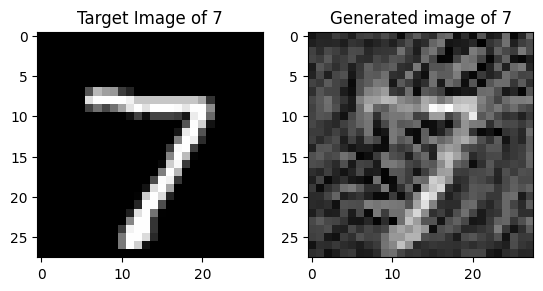

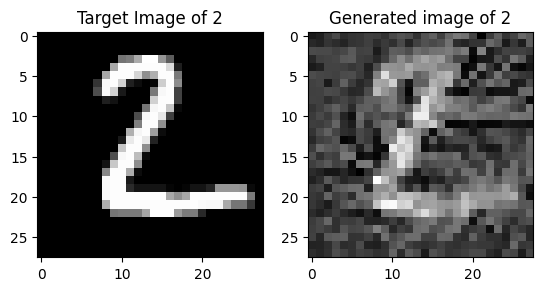

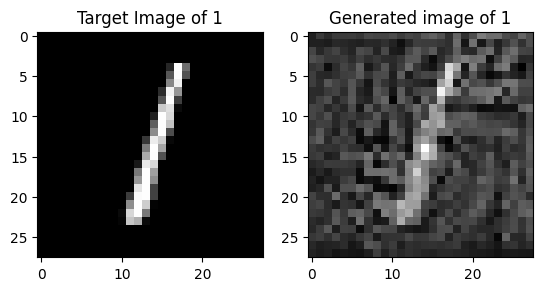

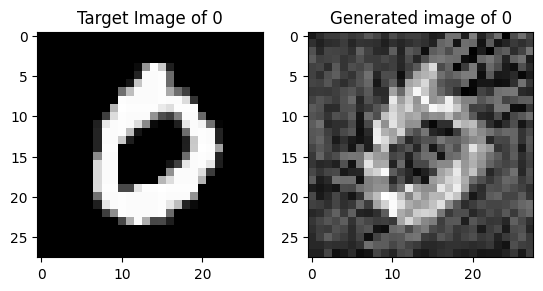

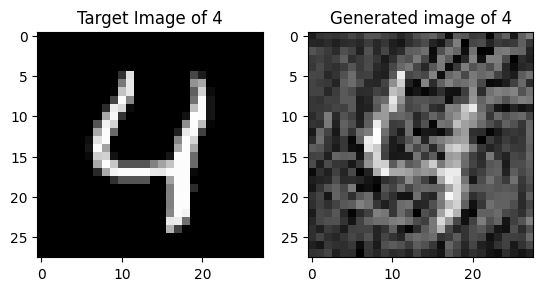

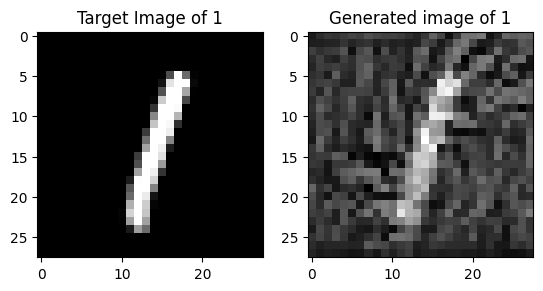

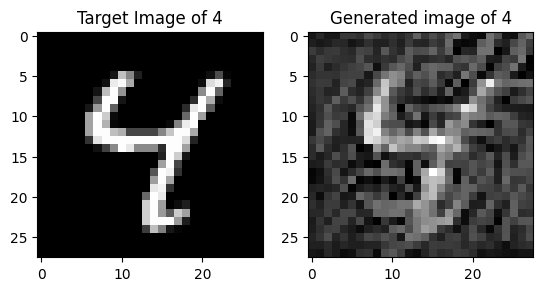

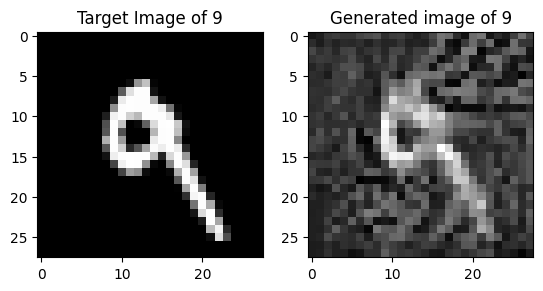

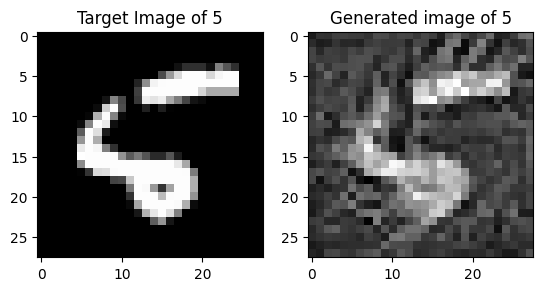

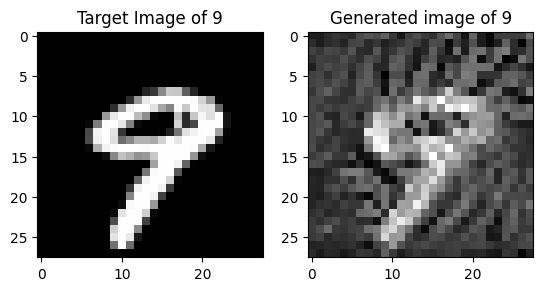

In [85]:
target_classes = [0,1,2,3,4,5,6,7,8,9]
gen_imgs_targeted_attack_with_noise = []
for i in range(0,len(target_classes)):
    gen_imgs_targeted_attack_with_noise.append(targeted_attack_with_noise(i,5))

**2. Sample a fixed set of 10 test examples from the dataset. Add the adversarial noise and classify. Show the true class
   and the predicted class. Repeat this for all the 10 generated adversarial noise matrices.**

Prediction of Generated Adverserial Image for digit 0


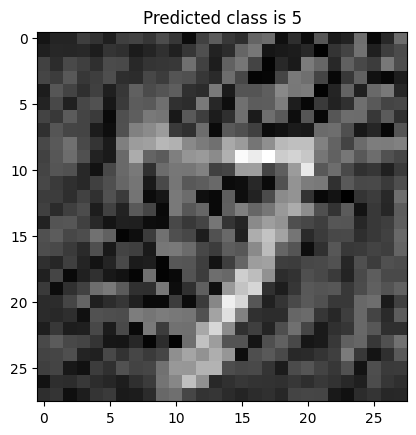

Prediction of Generated Adverserial Image for digit 1


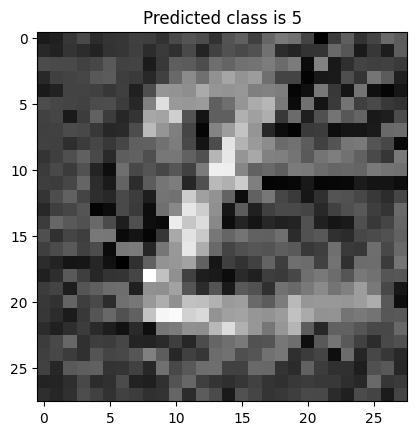

Prediction of Generated Adverserial Image for digit 2


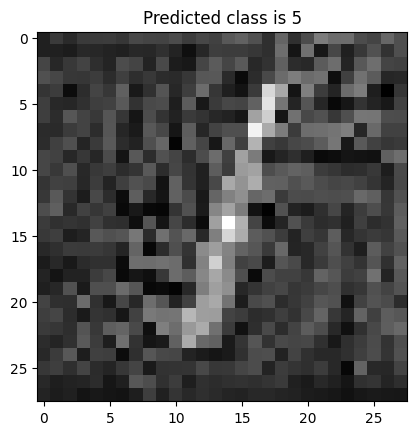

Prediction of Generated Adverserial Image for digit 3


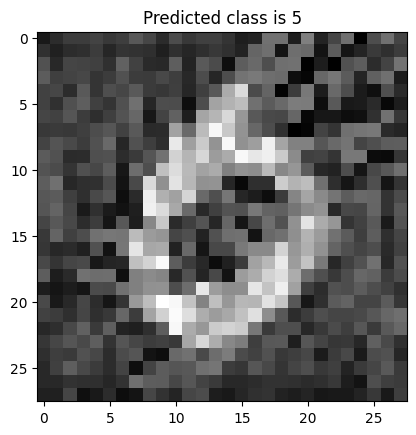

Prediction of Generated Adverserial Image for digit 4


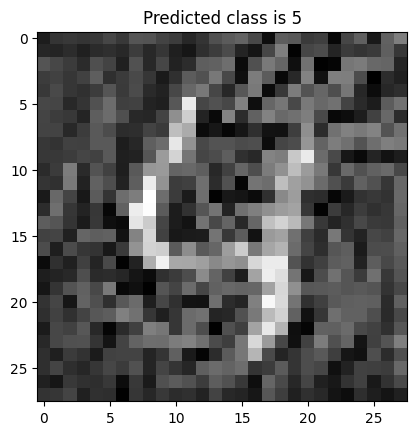

Prediction of Generated Adverserial Image for digit 5


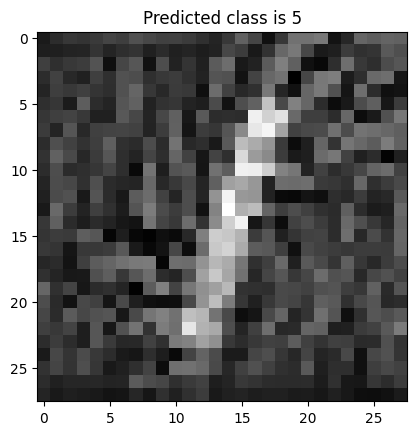

Prediction of Generated Adverserial Image for digit 6


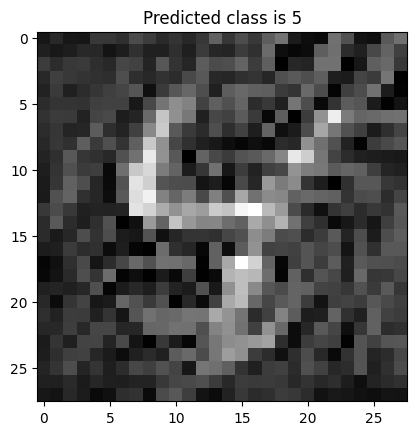

Prediction of Generated Adverserial Image for digit 7


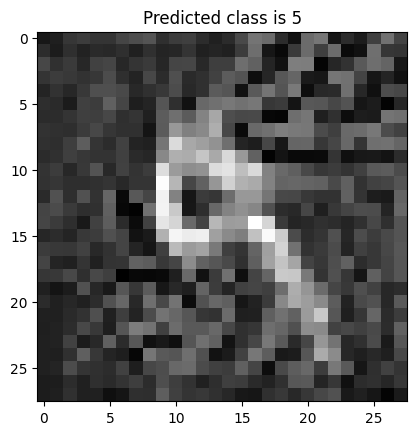

Prediction of Generated Adverserial Image for digit 8


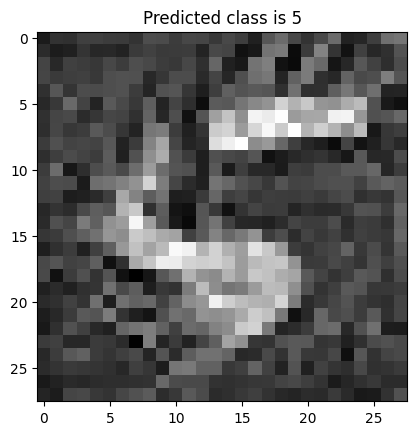

Prediction of Generated Adverserial Image for digit 9


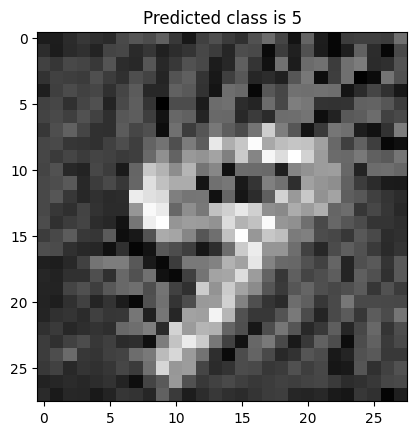

In [86]:
target_classes = [0,1,2,3,4,5,6,7,8,9]
for i in range(0,len(target_classes)):
    print("Prediction of Generated Adverserial Image for digit",i)
    predict(gen_imgs_targeted_attack_with_noise[i])